In [1]:
from a72_utilities import *
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import binary_dilation, binary_erosion
from seaborn import violinplot


In [2]:
def load_xas_ref_spectra():
    al = pd.read_csv("/Users/apple/Sync/Research/Alloy 72/Reference spectra/al_al2o3_xas_ref_wang.csv")
    ti = pd.read_csv("/Users/apple/Sync/Research/Alloy 72/Reference spectra/ti_tio_tio2_reference_Bzheumikhova.csv")
    ni = pd.read_csv("/Users/apple/Sync/Research/Alloy 72/Reference spectra/Ni_metal_oxide_XAS_ref.csv")
    cr = pd.read_csv("/Users/apple/Sync/Research/Alloy 72/Reference spectra/Cr_metal_oxide_XAS_ref.csv")
    fe = pd.read_csv("/Users/apple/Sync/Research/Alloy 72/Reference spectra/fe_fe2o3_ref_mohamad.csv")
    return {"Cr":cr,"Al":al,"Ni":ni,"Fe":fe,"Ti":ti}

def make_ref_arr(E,I, erange, shift=0):
    merged = pd.DataFrame({"Energy":E,"Intensity":I})
    merged = merged.drop_duplicates(subset=["Energy"])
    merged = merged.dropna()
    merged = merged.sort_values(by=["Energy"])

    spline = CubicSpline(merged["Energy"],merged["Intensity"],bc_type='natural')
    return normalize_array(spline(erange-shift))

def make_synthetic_series(metal_ref, oxide_ref, xrange,step=.01):
    """Take in two reference spectra and make a series of 100 linear combinations"""
    #Make a series of 100 linear combinations of metal and oxie reference spectra
    percentrange = np.arange(0,1.01,step)
    #print(percentrange.shape)
    synth = np.tile(percentrange,(len(metal_ref),1)).T
    print(synth.shape)
    synth_metal = np.tile(metal_ref,(len(percentrange),1))*synth
    synth_oxide = np.tile(oxide_ref,(len(percentrange),1))*(1-synth)
    synth_spectra = synth_metal+synth_oxide

    #plot all the synthetic spectra
    rb = plt.cm.get_cmap("bwr")
    for i,row in enumerate(synth_spectra):
        if i == 0:
            plt.plot(xrange, row,c = rb(i/len(percentrange)),label='Oxide')
        elif i == len(synth_spectra)-1:
            plt.plot(xrange, row,c = rb(i/len(percentrange)),label='Metal')
        else:
            plt.plot(xrange, row,c = rb(i/len(percentrange)),label='_nolegend_')
    plt.ylabel('Intensity (arb.u.)')
    plt.xlabel('Photon energy (eV)')
    plt.title('Synthetic Mixture of Cr(metal) and Cr(Oxide)')
    plt.legend()
    plt.show()
    return synth_spectra

def cosine_similarity_2d(line,reference):
    """Take the cosine similarity of two 1D vectors"""
    cosine = np.dot(line,reference)/(np.linalg.norm(line)*np.linalg.norm(reference))
    return cosine

def synth_series_to_CS(synth_spectra=None,metal_ref=None,oxide_ref=None):
    """calculate normalized cosine similarities for each synthetic mixture"""
    percentrange=np.arange(0,1.01,.01)
    oxide_cs_synth = np.zeros(percentrange.shape)
    oxide_cs_list = np.zeros(percentrange.shape)
    metal_cs_list = np.zeros(percentrange.shape)
    for i, row in enumerate(synth_spectra):
        metal_cs = cosine_similarity_2d(row,metal_ref)
        oxide_cs = cosine_similarity_2d(row,oxide_ref)
        oxide_cs_synth[i] = oxide_cs/(metal_cs+oxide_cs)
        oxide_cs_list[i] = oxide_cs
        metal_cs_list[i] = metal_cs
    params = np.polyfit(oxide_cs_synth,1-percentrange,3)
    oxide_cs_to_percent_polyfit = np.poly1d(params)
    plt.plot(1-percentrange,oxide_cs_synth)
    plt.xlabel("Oxide Fraction")
    plt.ylabel("Normalized Oxide Cosine Similarity")
    return oxide_cs_to_percent_polyfit

In [3]:
xas_elements, xas_masks,xas_energies = load_registered_xas()
xas_refs = load_xas_ref_spectra()
element_endpoints = {"Al":(75,89),"Cr":(571,581),"Fe":(703,716),"Ni":(848,864),"Ti":(452,470)}


     Cr ref    Cr ref E  Cr2o3 ref  Cr2o3 ref E  Cr ref.1  Unnamed: 5  \
0  0.597263  564.999634   0.807022   564.999259  0.001087         NaN   
1  0.597188  565.020167   0.806032   565.019049  0.000934         NaN   
2  0.597475  565.074160   0.805722   565.072024  0.001522         NaN   
3  0.597336  565.125039   0.802732   565.125820  0.001238         NaN   
4  0.596734  565.174478   0.802920   565.179177  0.000000         NaN   

   Cr2o3 ref.1  
0     0.073700  
1     0.072361  
2     0.071941  
3     0.067897  
4     0.068151  
581.0422535211268


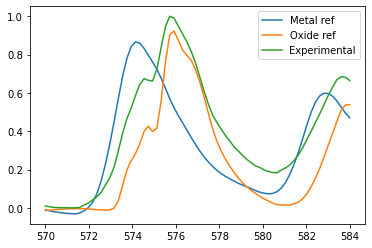

In [4]:
cr = xas_elements['Cr']
eshift = -1.7
#plt.imshow(cr[5,:,:])
cr_refs = xas_refs["Cr"]
print(cr_refs.head())
cr_metal,br = subtract_background((gaussian_filter1d(make_ref_arr(cr_refs["Cr ref E"],cr_refs["Cr ref"],erange=xas_energies['Cr'],shift = eshift),.8)),xas_energies['Cr'],element_endpoints['Cr'])
cr_oxide,br = subtract_background(gaussian_filter1d(make_ref_arr(cr_refs["Cr2o3 ref E"],cr_refs['Cr2o3 ref'],erange=xas_energies['Cr'], shift = eshift),.8),xas_energies['Cr'],element_endpoints['Cr'])

plt.plot(xas_energies["Cr"],cr_metal)
plt.plot(xas_energies["Cr"],cr_oxide)
plt.plot(xas_energies["Cr"],normalize_array(np.average(cr,axis=(1,2))))
plt.legend(["Metal ref","Oxide ref","Experimental"])
print(xas_energies['Cr'][56])

/Users/apple/vscode/Research/Alloy 72 work/a72_utilities.py:430: RuntimeWarning: invalid value encountered in true_divide
  cosine = np.dot(flat_image, reference) / (norm * np.linalg.norm(reference))


0.4820690836181685 0.4960890584857274


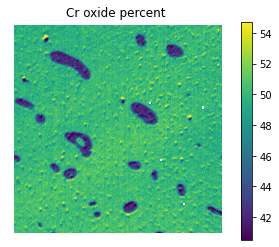

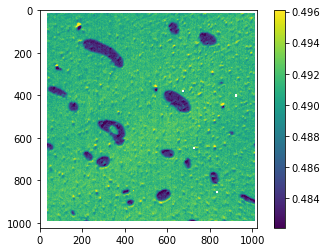

49.651625124271526


In [12]:
cr_metal_cosine = cosine_similarity_3d(xas_elements['Cr'][:56,:,:],normalize_array(cr_metal[:56]))
cr_oxide_cosine = cosine_similarity_3d(xas_elements['Cr'][:56,:,:],normalize_array(cr_oxide[:56]))
cr_normed_cs = cr_oxide_cosine/(cr_metal_cosine+cr_oxide_cosine)
# plt.imshow(cr_metal_cosine)
# plt.show()
# plt.imshow(cr_oxide_cosine)
# plt.show()
print(np.nanpercentile(cr_normed_cs,1), np.nanpercentile(cr_normed_cs,99))
cr_percent = oxide_cs_to_percent(cr_normed_cs)
plt.title("Cr oxide percent")
plt.imshow(cr_percent,vmin = np.nanpercentile(cr_percent,1), vmax = np.nanpercentile(cr_percent,99))
plt.axis('off')
plt.colorbar()
plt.show()
plt.imshow((cr_normed_cs),vmin=np.nanpercentile(cr_normed_cs,1), vmax=np.nanpercentile(cr_normed_cs,99))
plt.colorbar()
plt.show()
print(np.nanmean(cr_percent))

45.52406 4.109968


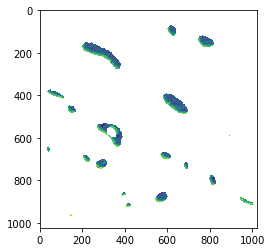

49.903645 2.3024545


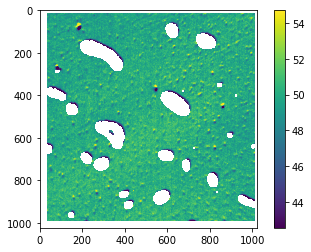

In [6]:
"""Get the mean and stdev of the Cr oxide in the l21 and fcc regions"""
cr_ox_l21= mask_subtract_arr(cr_percent, (xas_masks['Cr']),return_nan=True)
plt.imshow(cr_ox_l21,vmin=np.nanpercentile(cr_ox_l21,1), vmax=np.nanpercentile(cr_ox_l21,99))
print(np.nanmean(cr_ox_l21), np.nanstd(cr_ox_l21))
plt.show()
cr_ox_fcc = mask_subtract_arr(cr_percent,np.invert(xas_masks['Cr']),return_nan=True)
plt.imshow(cr_ox_fcc,vmin=np.nanpercentile(cr_ox_fcc,1), vmax=np.nanpercentile(cr_ox_fcc,99))
print(np.nanmean(cr_ox_fcc), np.nanstd(cr_ox_fcc))
plt.colorbar()

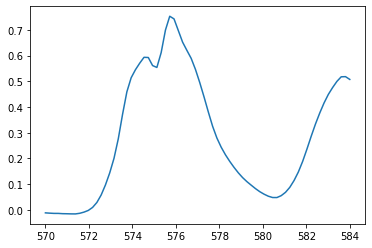

In [7]:
#visualize a 45/55 mix of metal and oxide
plt.plot(xas_energies["Cr"],cr_metal*.45+cr_oxide*.55)

   TiO2 Energy      TiO2  TiO Energy       TiO   Ti Energy       Ti 
0   451.949820  2.045617  451.726091  1.034432  451.446078  0.030075
1   452.117617  2.045617  451.893888  1.029183  451.983701  0.025156
2   452.285413  2.045617  452.061685  1.031569  452.151703  0.035654
3   452.453210  2.045617  452.229481  1.032523  452.401961  0.040100
4   452.621006  2.045617  452.397278  1.031569  452.655709  0.035654
Index(['TiO2 Energy', 'TiO2', 'TiO Energy', 'TiO', 'Ti Energy', 'Ti '], dtype='object')


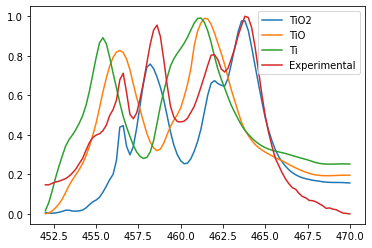

In [8]:
ti = xas_elements['Ti']
eshift = -1.8 
#plt.imshow(cr[5,:,:])
ti_refs = xas_refs["Ti"]
print(ti_refs.head())
print(ti_refs.keys())
tio2 = gaussian_filter1d(make_ref_arr(ti_refs["TiO2 Energy"],ti_refs["TiO2"],erange=xas_energies['Ti'],shift = eshift),.8)
tio = gaussian_filter1d(make_ref_arr(ti_refs["TiO Energy"],ti_refs['TiO'],erange=xas_energies['Ti'], shift = eshift),.8)
ti_metal = gaussian_filter1d(make_ref_arr(ti_refs["Ti Energy"],ti_refs["Ti "],erange = xas_energies["Ti"],shift = eshift),.8)
plt.plot(xas_energies["Ti"],tio2)
plt.plot(xas_energies["Ti"],tio)
plt.plot(xas_energies['Ti'],ti_metal)
plt.plot(xas_energies["Ti"],normalize_array(np.average(ti,axis=(1,2))))
plt.legend(["TiO2","TiO","Ti","Experimental"])

(101, 91)


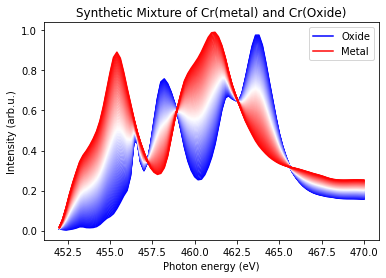

'Visualize the synthetic series and compare different shifts of the reference spectra to the experimental data\nThis if for the argument that our spectra are actually shifted with respect to the reference spectra'

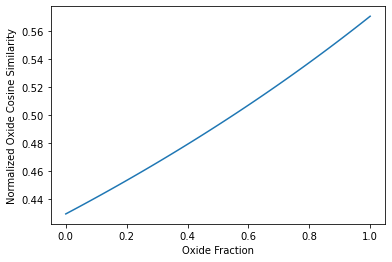

In [9]:
synth_Ti = make_synthetic_series(ti_metal,tio2,xas_energies['Ti'],step=.01)
synth_Ti_to_CS = synth_series_to_CS(synth_spectra=synth_Ti,metal_ref=ti_metal,oxide_ref=tio2)


"""Visualize the synthetic series and compare different shifts of the reference spectra to the experimental data
This if for the argument that our spectra are actually shifted with respect to the reference spectra"""
# plt.plot(xas_energies['Ti'],normalize_array(np.nanmean(ti,axis=(1,2))))
# plt.plot(xas_energies['Ti'],synth_Ti[3])
# plt.legend(['Experimental','70% TiO2, 30% Ti'])
# plt.xlabel('Photon energy (eV)')
# plt.title('Synthetic mixture with shift')
# plt.show()
# plt.plot(xas_energies['Ti'],normalize_array(np.nanmean(ti,axis=(1,2))))
# plt.plot(xas_energies['Ti']+1.8,synth_Ti[3])
# plt.legend(['Experimental','70% TiO2, 30% Ti'])
# plt.xlabel('Photon energy (eV)')
# plt.title('Synthetic mixture without shift')

In [10]:
#visualize a 70/30 mix of tio2 and ti metal and copy it to the clipboard
# mixed_spectra = pd.DataFrame({'Energy':(xas_energies['Ti']),'Ti 70/30':synth_Ti[3]})
# mixed_spectra.to_clipboard(index=False)

/Users/apple/vscode/Research/Alloy 72 work/a72_utilities.py:430: RuntimeWarning: invalid value encountered in true_divide
  cosine = np.dot(flat_image, reference) / (norm * np.linalg.norm(reference))


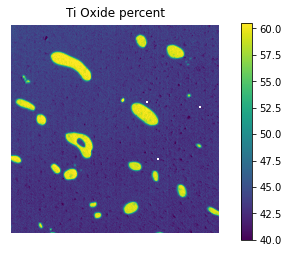

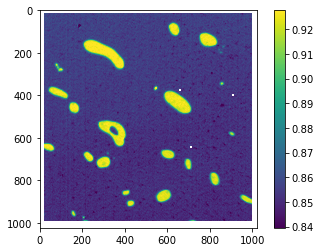

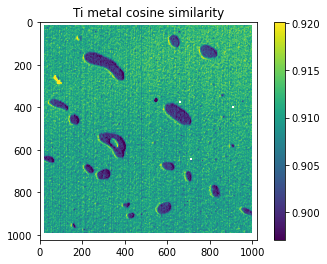

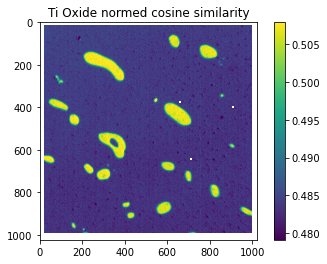

In [11]:
ti_metal_cosine = cosine_similarity_3d(xas_elements['Ti'],ti_metal)
tio2_cosine = cosine_similarity_3d(xas_elements['Ti'],tio2)
#XPS indicates that there is no TiO in the sample, so it's ignored here
#tio_cosine = cosine_similarity_3d(xas_elements['Ti'],tio)
tio2_normed_cs = tio2_cosine/(ti_metal_cosine+tio2_cosine)
tio2_percent = synth_Ti_to_CS(tio2_normed_cs)*100
plt.imshow(tio2_percent,vmin = np.nanpercentile(tio2_percent,1), vmax = np.nanpercentile(tio2_percent,99))
plt.title("Ti Oxide percent")
plt.colorbar()
plt.axis('off')
plt.show()
plt.imshow(tio2_cosine,vmin=np.nanpercentile(tio2_cosine,1), vmax=np.nanpercentile(tio2_cosine,99))
plt.colorbar()
plt.show()
plt.imshow(ti_metal_cosine,vmin=np.nanpercentile(ti_metal_cosine,1), vmax=np.nanpercentile(ti_metal_cosine,99))
plt.title("Ti metal cosine similarity")
plt.colorbar()
plt.show()
plt.imshow(tio2_normed_cs,vmin=np.nanpercentile(tio2_normed_cs,1), vmax=np.nanpercentile(tio2_normed_cs,99))
plt.title("Ti Oxide normed cosine similarity")
plt.colorbar()
plt.show()

55.745716 6.1709776


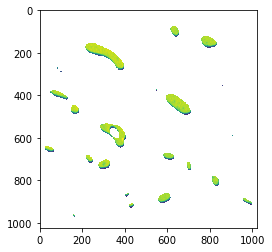

43.53088 2.1644304


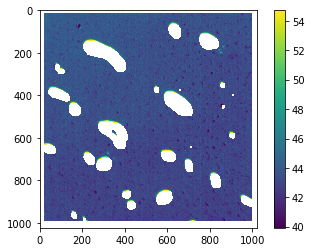

In [39]:
"""Get the mean and stdev of the Ti oxide in the l21 and fcc regions"""
Ti_ox_l21 = mask_subtract_arr(tio2_percent, (xas_masks['Ti']),return_nan=True)
plt.imshow(Ti_ox_l21,vmin=np.nanpercentile(Ti_ox_l21,1), vmax=np.nanpercentile(Ti_ox_l21,99))
print(np.nanmean(Ti_ox_l21), np.nanstd(Ti_ox_l21))
plt.show()
Ti_ox_fcc = mask_subtract_arr(tio2_percent,np.invert(xas_masks['Ti']),return_nan=True)
plt.imshow(Ti_ox_fcc,vmin=np.nanpercentile(Ti_ox_fcc,1), vmax=np.nanpercentile(Ti_ox_fcc,99))
print(np.nanmean(Ti_ox_fcc), np.nanstd(Ti_ox_fcc))

plt.colorbar()

TypeError: 'str' object is not callable

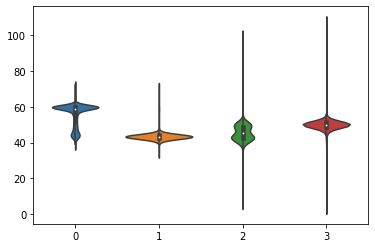

In [ ]:
fig =violinplot(data=[Ti_ox_l21[~np.isnan(Ti_ox_l21)],Ti_ox_fcc[~np.isnan(Ti_ox_fcc)],cr_ox_l21[~np.isnan(cr_ox_l21)],cr_ox_fcc[~np.isnan(cr_ox_fcc)]])


      Fe2O3 E     Fe2O3        Fe E        Fe
0  702.977469  0.292504  702.816058  0.249288
1  705.936683  0.291304  703.192685  0.249288
2  706.582330  0.339323  704.214959  0.263693
3  707.156238  0.411351  704.860606  0.263693
4  707.658408  0.504987  705.506252  0.278099


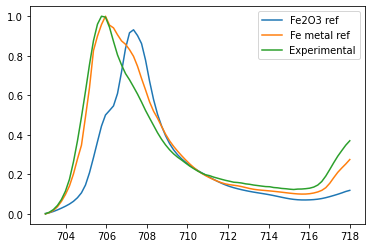

In [12]:
fe_refs = xas_refs["Fe"]
fe_shift = -3.1
print(fe_refs.head())
fe_metal = make_ref_arr(fe_refs["Fe E"],fe_refs["Fe"],erange=xas_energies["Fe"],shift=fe_shift)
fe2o3 = gaussian_filter1d(make_ref_arr(fe_refs["Fe2O3 E"], fe_refs["Fe2O3"],erange=xas_energies["Fe"],shift=fe_shift),1)

plt.plot(xas_energies["Fe"],fe2o3)
plt.plot(xas_energies["Fe"],fe_metal)
plt.plot(xas_energies["Fe"],normalize_array(np.average(xas_elements["Fe"],axis=(1,2))))
plt.legend(["Fe2O3 ref","Fe metal ref","Experimental"])

/Users/apple/vscode/Research/Alloy 72 work/a72_utilities.py:429: RuntimeWarning: invalid value encountered in true_divide
  cosine = np.dot(flat_image, reference) / (norm * np.linalg.norm(reference))


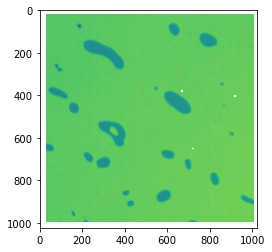

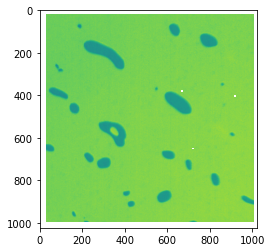

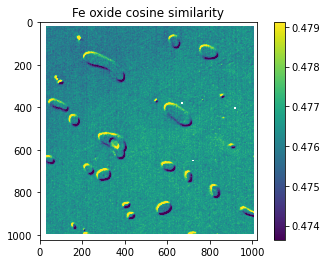

In [13]:
fe_metal_cosine = cosine_similarity_3d(xas_elements["Fe"],fe_metal)
fe_oxide_cosine = cosine_similarity_3d(xas_elements['Fe'],fe2o3)
normed_fe_oxide_cs = fe_oxide_cosine/(fe_metal_cosine+fe_oxide_cosine)
plt.imshow(fe_metal_cosine)
plt.show()
plt.imshow(fe_oxide_cosine)
plt.show()
plt.imshow(normed_fe_oxide_cs,vmin=np.nanpercentile(normed_fe_oxide_cs,1), vmax=np.nanpercentile(normed_fe_oxide_cs,99))
plt.title("Fe oxide cosine similarity")
plt.colorbar()
plt.show()

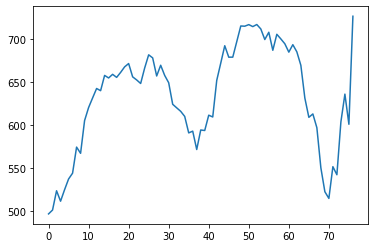

In [17]:
al_br_subtracted = imread('/Users/apple/Sync/Research/Alloy 72/Background subtraction/Al_XAS_Br_subtracted_raw.tif')
plt.plot(np.nanmean(al_br_subtracted,axis=(1,2)))

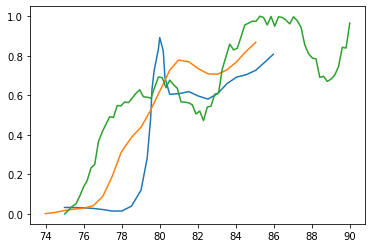

In [15]:
plt.plot(xas_refs['Al']["Al2O3 E"],gaussian_filter1d(normalize_array(xas_refs['Al']["Al2O3"]),1))
plt.plot(xas_refs['Al']["Al E"],gaussian_filter1d(normalize_array(xas_refs['Al']["Al"]),1))
plt.plot(xas_energies['Al'],normalize_array(np.nanmean(al_br_subtracted,axis=(1,2,))))

76.97368421052632 78.94736842105263 80.92105263157895


Text(0.5, 1.0, 'Estimate of Al oxide fraction from integrated intensities')

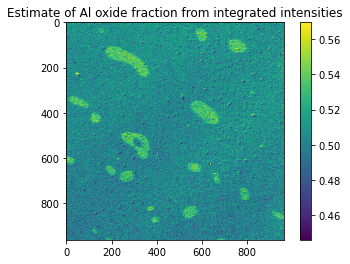

In [22]:
rough_al_metal = np.sum(al_br_subtracted[10:20,:,:],axis=0)
rough_al_oxide = np.sum(al_br_subtracted[20:30,:,:],axis=0)
print(xas_energies['Al'][10], xas_energies['Al'][20], xas_energies['Al'][30])
al_ox_frac_est = rough_al_oxide/(rough_al_metal+rough_al_oxide)
plt.imshow(al_ox_frac_est, vmin=np.nanpercentile(al_ox_frac_est,1),vmax =np.nanpercentile(al_ox_frac_est,99))
plt.colorbar()
plt.title("Estimate of Al oxide fraction from integrated intensities")

In [ ]:
"""Try out experimental reference spectra from the synchrotron oxidation experiment"""
# experimental_refs = {}
# metal_ref_dir = "/Users/apple/Sync/Research/Alloy 72/Reference spectra/Experimental Metal Refs"
# for root, dirs, files in os.walk(metal_ref_dir):
#     for file in files:
#         if file.endswith('.csv'):
#             xas_ref = pd.read_csv(os.path.join(root,file))
#             experimental_refs[file.split(".")[0]] = xas_ref
#             plt.plot(xas_ref["Energy"],xas_ref["Intensity"])
#             plt.show()

In [ ]:
"""Plot all the experimental refs against the native oxide spectra"""
# for element in experimental_refs.keys():
#     plt.plot(xas_energies[element],normalize_array(np.average(xas_elements[element],axis=(1,2))), label="Native oxide")
#     plt.plot(experimental_refs[element]['Energy'],normalize_array(experimental_refs[element]['Intensity']),label='Sputtered')
#     plt.title(element)
#     plt.show()